In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))

In [2]:
import sys
sys.path.append(wd+"\\src\\")
from tube import Tube, InterpXY
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from pistonlayer import ElPistLayer, ElPistEOS
from powderlayer import Powder, PowderOvLayer
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [19]:
import json
from functional import seq

### Труба

In [5]:
tube_dict_sample = {
    'tube_points': [[0, 0.023], [1, 0.023], [1.3, 0.023*0.5], [1.5, 0.023*0.5]]
}

def get_tube(**tube_dict):
    if 'tube_points' not in tube_dict:
        raise Exception(f'В функции get_tube(**tube_dict) неправильные аргументы tube_dict={tube_dict}')
    xs, ds = [], []
    for x, d in tube_dict['tube_points']:
        xs.append(x)
        ds.append(d)
    return Tube(xs, ds)

get_tube(**tube_dict_sample)

Tube(xs=[0.0, 1.0, 1.3, 1.5], ds=[0.023, 0.023, 0.0115, 0.0115])

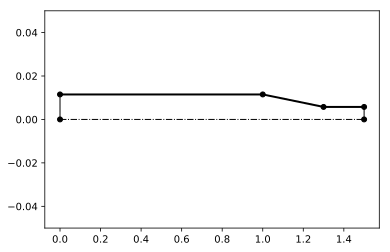

In [40]:
def plot_tube(tube: Tube, ax, fig):
    xs, ys = np.array(tube.get_xs()), np.array(tube.get_ds())/2
    fig.plot(xs, ys, color='black', lw=2, marker='o', markersize=5)
    fig.plot(xs[[0,0]], [0, ys[0]], color='black', lw=1)
    fig.plot(xs[[-1,-1]], [0, ys[-1]], color='black', lw=1)
    fig.plot(xs[[0,-1]], [0,0], color='black', lw=1, ls='-.', marker='o', markersize=5)
    
ax, fig = plt.subplots()
tube = get_tube(**tube_dict_sample)
plot_tube(tube, ax, fig)
fig.set_ylim(-0.05,0.05)
plt.show()

### Граница

In [ ]:
class Border(object):
    def __init__(self, lr_left, lr_right, mass, p_f, t_init=-1):
        self.lr_left= lr_left
        self.lr_right = lr_right
        self.mass = mass
        self.p_f = p_f
        self.t_init = t_init
        

### Пороховой слой

In [6]:
with open('gpowders.json') as f:
    all_powders = json.load(f)
    
all_powders.keys()
all_powders['4\\7']

{'name': '4\\7',
 'f': 1.027,
 'etta': 0.228,
 'alpha_k': 1.008,
 'T_1': 3006.0,
 'ro': 1.6,
 'I_k': 0.32,
 'Z_k': 1.488,
 'k_1': 0.811,
 'lambda_1': 0.081,
 'k_2': 0.505,
 'lambda_2': -1.024,
 'k_f': 0.0003,
 'k_l': 0.0016}

In [7]:
powder_layer_dict_sample = {
    'type': 'PowderOvLayer',
    'powder': {
        'name': '4\\7',
        'f': 1.027,
        'etta': 0.228,
        'alpha_k': 1.008,
        'T_1': 3006.0,
        'ro': 1.6,
        'I_k': 0.32,
        'Z_k': 1.488,
        'k_1': 0.811,
        'lambda_1': 0.081,
        'k_2': 0.505,
        'lambda_2': -1.024,
        'k_f': 0.0003,
        'k_l': 0.0016
    },
    'omega': 35,  # грамм
    'delta': 700, # г/cm^3
    'p_0': 5e6, # начальное давление
    't_ign': 0.00001, # начало горения
}

calc_settings_sample = {
    'cell_dx': 0.001,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {},
    'GridStrecher_kwargs': {}
}
def get_n_cells(x_1, x_2, calc_settings):
    n_cells = round(abs(x_2-x_1)/calc_settings['cell_dx'])
    n_cells = min(calc_settings['n_cells_max'], n_cells)
    n_cells = max(calc_settings['n_cells_min'], n_cells)
    return n_cells

def get_powder_ov_layer(tube: Tube, x_1: float, powder_layer_dict, calc_settings):
    powder = Powder.from_bd(powder_layer_dict['powder'])
    flux_calculator = GasFluxCalculator(**calc_settings['GasFluxCalculator_kwargs'])
    grid_strecher = GridStrecher(**calc_settings['GridStrecher_kwargs'])
    omega = powder_layer_dict['omega']*1e-3
    delta = powder_layer_dict['delta']
    w = omega/delta
    x_2 = tube.get_x2(x_1, w)
    n_cells = get_n_cells(x_1, x_2, calc_settings)
    pow_layer = PowderOvLayer(n_cells=n_cells, tube=tube, powder=powder, 
                              flux_calculator=flux_calculator, grid_strecher=grid_strecher,
                              t_ign=powder_layer_dict['t_ign'])
    pow_layer.xs_borders = np.linspace(x_1, x_2, n_cells+1)
    def foo_ropu(*args):
        return delta, powder_layer_dict['p_0'], 0, 0
    pow_layer.init_ropue_fromfoo(foo_ropu)
    return pow_layer
    

In [8]:
tube=get_tube(**tube_dict_sample)
pl = get_powder_ov_layer(tube, 0.1, powder_layer_dict_sample, calc_settings_sample)
pl

PowderOvLayer(n_cells=120); {'p_max':5000000.0, 'tau_min': 8.030994023529108e-06, \
        'u_max': 0.0, 'cs_max': 124.87454021397153, 'dx_min': 0.0010028666861493507, 'x_1': 0.1, 'x_2': 0.2203440023379244,\
        'V_1':  0.0, 'V_2':  0.0  }{ 'powder': r'4\7', 'z_max': 0.0 }

### Газовый слой

In [11]:
gas_layer_dict_sample = {
    'type': 'gas',
    'name': 'air',
    'gamma': 1.4,
    'kappa': 0.0010838,
    'R': 287,
    'T_0': 300, # K
    'V_0': 0.0002,  # м^3 объем газа
    'p_0': 100e5, # начальное давление газа
}

def get_gas_layer(tube: Tube, x_1: float, gas_layer_dict, calc_settings):
    flux_calculator = GasFluxCalculator(**calc_settings['GasFluxCalculator_kwargs'])
    grid_strecher = GridStrecher(**calc_settings['GridStrecher_kwargs'])
    
    p_0 = gas_layer_dict['p_0']
    ro_0 = p_0/(gas_layer_dict['R']*gas_layer_dict['T_0'] + p_0*gas_layer_dict['kappa'])
    gas_eos = GasEOS(gamma=gas_layer_dict['gamma'], kappa=gas_layer_dict['kappa'], kind=1)
    
    x_2 = tube.get_x2(x_1, gas_layer_dict['V_0'])
    n_cells = get_n_cells(x_1, x_2, calc_settings)
    
    glayer = GasLayer(n_cells=n_cells, tube=tube, gasEOS=gas_eos, flux_calculator=flux_calculator, grid_strecher=grid_strecher)
    glayer.xs_borders = np.linspace(x_1, x_2, n_cells+1)
    def foo_ropu(*args):
        return ro_0, p_0, 0
    glayer.init_ropue_fromfoo(foo_ropu)
    return glayer

tube=get_tube(**tube_dict_sample)
gl = get_gas_layer(tube, 0.2, gas_layer_dict_sample, calc_settings_sample)   
gl

GasLayer(n_cells=300); {'p_max':10000000.0, 'tau_min': 4.104938833462682e-06, \
        'u_max': 0.0, 'cs_max': 390.8917435646241, 'dx_min': 0.0016045866978383616, 'x_1': 0.2, 'x_2': 0.6813760093515384,\
        'V_1':  0.0, 'V_2':  0.0  }

### Полиэтиленовый слой

In [18]:
pist_layer_dict_sample = {
    'type': 'pist',
    'omega': 0.03,  # кг
    'p_0': 1e5, # начальное давление в полиэтилене
    
    'ElPistEOS_kwargs': dict(
        k=1.63098, 
        c_0=2308, 
        ro_0=919.03, 
        sigma_star=25.2, 
        k_0=0.054, 
        b_1=0.027, 
        b_2=0.00675, 
        tau_0=1.36, 
        mu=0.001, 
        tau_s=1,                 
        zeroP=False, 
        zeroE=True)
}

def get_pist_layer(tube: Tube, x_1: float, gas_layer_dict, calc_settings):
    flux_calculator = GasFluxCalculator(**calc_settings['GasFluxCalculator_kwargs'])
    grid_strecher = GridStrecher(**calc_settings['GridStrecher_kwargs'])
    epistEOS = ElPistEOS(**gas_layer_dict['ElPistEOS_kwargs'])
    ro_0 = gas_layer_dict['ElPistEOS_kwargs']['ro_0']
    
    W0 = gas_layer_dict['omega']/ro_0
    x_2 = tube.get_x2(x_1, W0)
    n_cells = get_n_cells(x_1, x_2, calc_settings)
    pist_layer = ElPistLayer(n_cells=n_cells, tube=tube, epistEOS=epistEOS, flux_calculator=flux_calculator, grid_strecher=grid_strecher)
    pist_layer.xs_borders = np.linspace(x_1, x_2, n_cells+1)
    def foo_ropu(*args):
        return ro_0, gas_layer_dict['p_0'], 0
    pist_layer.init_ropue_fromfoo(foo_ropu)
    return pist_layer

tube=get_tube(**tube_dict_sample)
pistl = get_pist_layer(tube, 0.2, pist_layer_dict_sample, calc_settings_sample)   
pistl 

ElPistLayer(n_cells=79); {'p_max':100000.0, 'tau_min': 4.3089939362628795e-07, \
        'u_max': 0.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.0009945323667853168, 'x_1': 0.2, 'x_2': 0.2785680569760416,\
        'V_1':  0.0, 'V_2':  0.0  }

0.0